In [1]:
# Imports
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
#!python -m spacy download en_core_web_sm

import PyPDF2

In [2]:
# Load spacy english language model
NER = spacy.load('en_core_web_sm')

In [3]:
import os
import time
startTime = time.time()

# Load all books from path
all_books = [i for i in os.scandir("C:\\Users\\sruth\\Desktop\\Work\\Git_projects\\Character Analysis of Harry Potter books using Spacy\\Jupyter notebooks") if '.pdf' in i.name]

# Opening file and Creating a pdf reader object
file = open(all_books[0], 'rb')
fileReader = PyPDF2.PdfReader(file)

# Extract text from the book
page = fileReader.pages[0]
text = page.extract_text()
for i in range(1,len(fileReader.pages)):
    page_s = fileReader.pages[i]
    text_s = page_s.extract_text()
    text +=text_s
    

# NER
book_doc = NER(text)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime/60))

Execution time in seconds: 0.9016978025436402


In [4]:
# Visualize the identified entities
displacy.render(book_doc[0:2000],style='ent',jupyter=True)

In [5]:
# Load web scraped characters data
names = pd.read_csv('characters.csv')

# Filtering names with more than 3 words
names['word_count'] = names['character'].apply(lambda x: len(x.split()))
names = names[(names.word_count==1) | (names.word_count==2)]
names.drop('word_count',inplace=True, axis=1)

# First and Last name columns from names
names['first_name'] = names['character'].apply(lambda x: x.split(' ')[0])
names['last_name'] = names['character'].apply(lambda x: x.split(' ')[0] if len(x.split(' '))==1 else x.split(' ')[1])
names.head()

,book,character,first_name,last_name
0,Harry Potter and the Chamber of Secrets,Mr Mason,Mr,Mason
1,Harry Potter and the Chamber of Secrets,Mrs Mason,Mrs,Mason
2,Harry Potter and the Chamber of Secrets,Dobby,Dobby,Dobby
3,Harry Potter and the Chamber of Secrets,Mafalda Hopkirk,Mafalda,Hopkirk
4,Harry Potter and the Chamber of Secrets,Errol,Errol,Errol


In [6]:
# Get named entity for each sentence in the book.
entity = []

# Create dataframe with sentences and entity in it.
for i in book_doc.sents:
    entity_list = [ent.text for ent in i.ents]
    entity.append({"sentence":i, "entities":entity_list})
    
entity_df = pd.DataFrame(entity)

In [7]:
# Filter out non-entities
def filter_entity(ent_list, df):
    return [ent for ent in ent_list
           if ent in list(df.character)
           or ent in list(df.first_name)
           or ent in list(df.last_name)]

# Apply filter_entity function and remove empty lists
entity_df['character_entities'] = entity_df['entities'].apply(lambda x: filter_entity(x, names))
entity_df_filtered = entity_df[entity_df['character_entities'].map(len)>0]
entity_df_filtered = entity_df_filtered.reset_index(drop=True)

In [8]:
# Identify relationships between characters
window_size = 10 # 10 sentences
relationships = []

for i in range(entity_df_filtered.index[-1]):
    end_i = min(i+10,entity_df_filtered.index[-1])
    char_list = sum((entity_df_filtered.loc[i:end_i].character_entities), [])
    
    # Removing duplicates from the list
    char_list_unique = np.unique(char_list)
    char_list_unique = list(char_list_unique)
    
    if len(char_list_unique)>1:
        for index, name in enumerate(char_list_unique[:-1]):
            nex = char_list_unique[index+1]
            text = char_list_unique[index] +' '+ nex
            text_c = nex+' '+char_list_unique[index]
            # Removing relationships where same name appears (first and last)
            if (names['character'].isin([text])).sum()==0 and (names['character'].isin([text_c])).sum()==0: 
                relationships.append({"source":name, "target":nex})
        
# Creating DataFrame from the created list
relationships_df = pd.DataFrame(relationships)
relationships_df.head() 

,source,target
0,Dursley,Harry
1,Dursley,Harry
2,Dursley,Harold
3,Harold,Harry
4,Dursley,Harold


In [9]:
# Sort values in relationships_df
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis = 1), columns = relationships_df.columns)

# Calculate weightage for each relationship
relationships_df['value'] = 1
relationships_df = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()

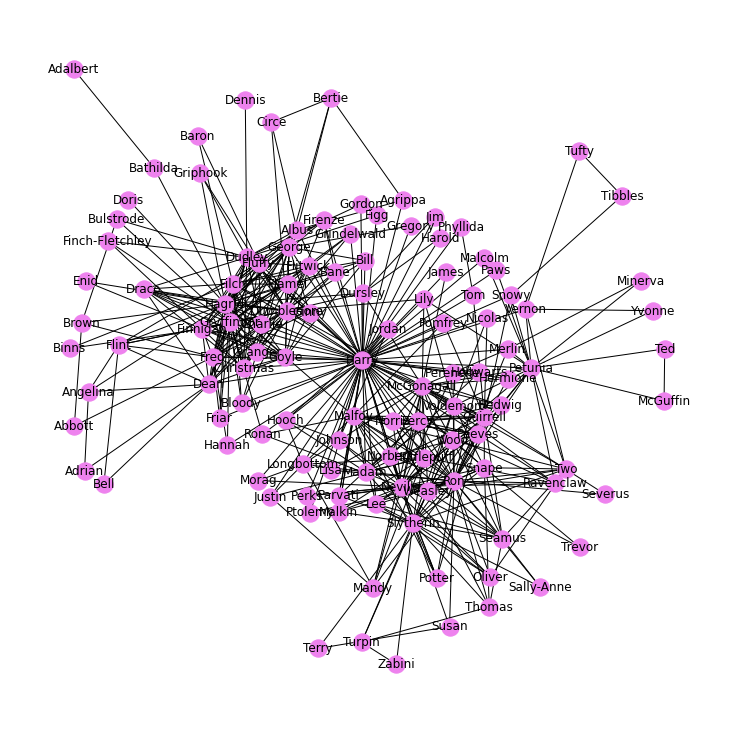

In [29]:
# Graph Analysis and Visualization
# Create a graph from a pandas dataframe

graph = nx.from_pandas_edgelist(relationships_df,
                               source = 'source',
                               target = 'target',
                               edge_attr = 'value',
                               create_using = nx.Graph())

# Graph Visualization
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, with_labels=True, node_color='violet', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [36]:
# Visualization with pyvis
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='remote')

node_degree = dict(graph.degree)

nx.set_node_attributes(graph, node_degree, 'size')
net.from_nx(graph)
net.show("harry_potter.html")

<AxesSubplot:>

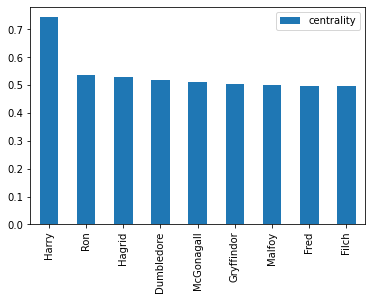

In [41]:
# Finding out important characters using centrality measures

## Using Degree centrality
degree_dict = nx.degree_centrality(graph)
degree_dict

# Visualization
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

# Plotting top 10 nodes
degree_df.sort_values('centrality',ascending=False)[0:9].plot(kind='bar')

## Using betweenness_centrality
betweenness_dict = nx.betweenness_centrality(graph)
betweenness_dict

# Visualization
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])

# Plotting top 10 nodes
betweenness_df.sort_values('centrality',ascending=False)[0:9].plot(kind='bar')

## Using closeness_centrality
closeness_dict = nx.closeness_centrality(graph)
closeness_dict

# Visualization
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

# Plotting top 10 nodes
closeness_df.sort_values('centrality',ascending=False)[0:9].plot(kind='bar')

In [ ]:
# Community Detection

# Save centrality measures
nx.set_node_attributes(graph, degree_dict, 'degree_centrality')
nx.set_node_attributes(graph, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(graph, closeness_dict, 'closeness_centrality')



In [11]:
# Steps:
# Loaded data and got NER with spacy on the first book.
# Created a csv with relationship by filtering NER of character names within 5 sentences.
# Remove character names that had more than 3 words from character.csv
# If there are more than 2 characters in char_list_unique list, create relationships between each two.

# To do:
# Experiment with 5 or 10 sentence windows.
# Add all books. If relationships are lot, remove less values.

# Read me:
# Centrality measures - 18.30
# Community Detection - 20

In [12]:
# import PyPDF2

# # creating an object
# file = open('Jaya_Suruthi.pdf', 'rb')

# # creating a pdf reader object
# fileReader = PyPDF2.PdfReader(file)

# # print the number of pages in pdf file
# #print(len(fileReader.pages))
# page = fileReader.pages[0]
# print(page.extract_text())

# Time taken
import time
startTime = time.time()
#
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime/60))

Execution time in seconds: 0.0
